# Final Exam - Take Home Key (65 pts)

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.mixture import GaussianMixture
from pomegranate import *

---
### This exam will deal with two single channel current recordings taken under two different sets of conditions in the absence and presence of an activating stimulus.

The cell below will load the two data sets from file. You may have to edit the file paths to reflect where you have stored these datasets locally on your computer.

In [2]:
import pickle

with open("single_channel_nonactivated.dat", "rb") as f:
    time_ms, nonactivated_current_pA = pickle.load(f)

with open("single_channel_activated.dat", "rb") as f:
    time_ms, activated_current_pA = pickle.load(f)

---
### 1. (5 pts) Plot the first 5,000 time points of each single channel current record from nonactivating and activating conditions on separate axes. Visually, what do you think is the biggest difference between the two conditions?

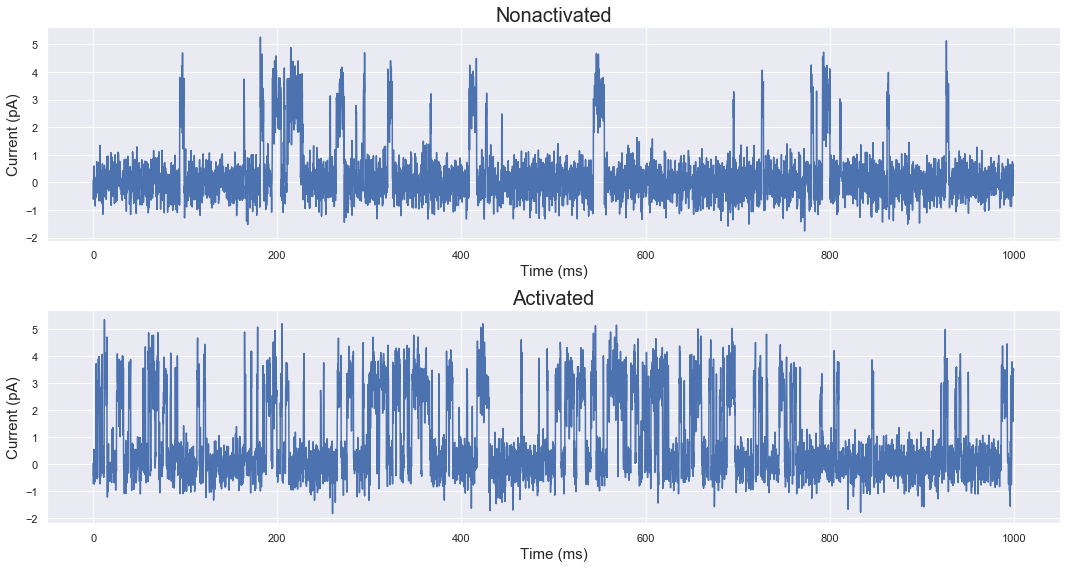

In [3]:
plt.figure(figsize=(15, 8))
n = 5000

plt.subplot(211)
plt.plot(time_ms[:n], nonactivated_current_pA[:n])
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Current (pA)', fontsize=15)
plt.title('Nonactivated', fontsize=20)

plt.subplot(212)
plt.plot(time_ms[:n], activated_current_pA[:n])
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Current (pA)', fontsize=15)
plt.title('Activated', fontsize=20)

plt.tight_layout();

By eye, the main difference is that closures are shorter and openings more frequent in the activating condition as compared to the nonactivating condition.

---
### 2. (10 pts) For each condition, plot a histogram of the single channel current amplitudes (scaled to match a probability density function) overlaid with a fit for the probability density function for a weighted mixture of multiple Gaussians to the current amplitude distributions. You decide how many Gaussians to include.

*Hint:* Decide solely based on your visual examination of the amplitude histograms.

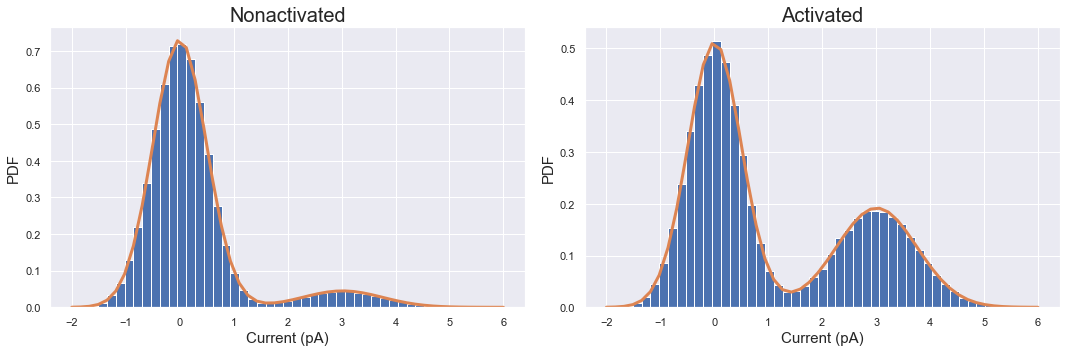

In [4]:
nonactivated_gmm = GaussianMixture(n_components=2, random_state=0)
activated_gmm = GaussianMixture(n_components=2, random_state=0)

nonactivated_gmm.fit(nonactivated_current_pA.reshape(-1, 1))
activated_gmm.fit(activated_current_pA.reshape(-1, 1))

bins = np.linspace(-2, 6, 50)
nonactivated_amp_pdf = np.zeros(bins.shape)
activated_amp_pdf = np.zeros(bins.shape)
for i in range(2):
    A = nonactivated_gmm.weights_[i]
    mu = np.squeeze(nonactivated_gmm.means_)[i]
    sigma = np.sqrt(np.squeeze(nonactivated_gmm.covariances_)[i])
    nonactivated_amp_pdf += A * st.norm.pdf(bins, mu, sigma)
    
    A = activated_gmm.weights_[i]
    mu = np.squeeze(activated_gmm.means_)[i]
    sigma = np.sqrt(np.squeeze(activated_gmm.covariances_)[i])
    activated_amp_pdf += A * st.norm.pdf(bins, mu, sigma)

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(nonactivated_current_pA, bins, density=True)
plt.plot(bins, nonactivated_amp_pdf, lw=3)
plt.xlabel('Current (pA)', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title('Nonactivated', fontsize=20)

plt.subplot(122)
plt.hist(activated_current_pA, bins, density=True)
plt.plot(bins, activated_amp_pdf, lw=3)
plt.xlabel('Current (pA)', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title('Activated', fontsize=20)

plt.tight_layout();

---
### 3. (10 pts) Based on the mixture of Gaussians you fit to the current amplitude distributions, generate idealized cluster sequences for each current record. i.e. the idealized cluster sequence will be a sequence of integers indicating which current level or Gaussian cluster each data point belongs. Make a scatter plot of the first 5,000 time points of each single channel current record and color each data point according to which cluster it belongs.

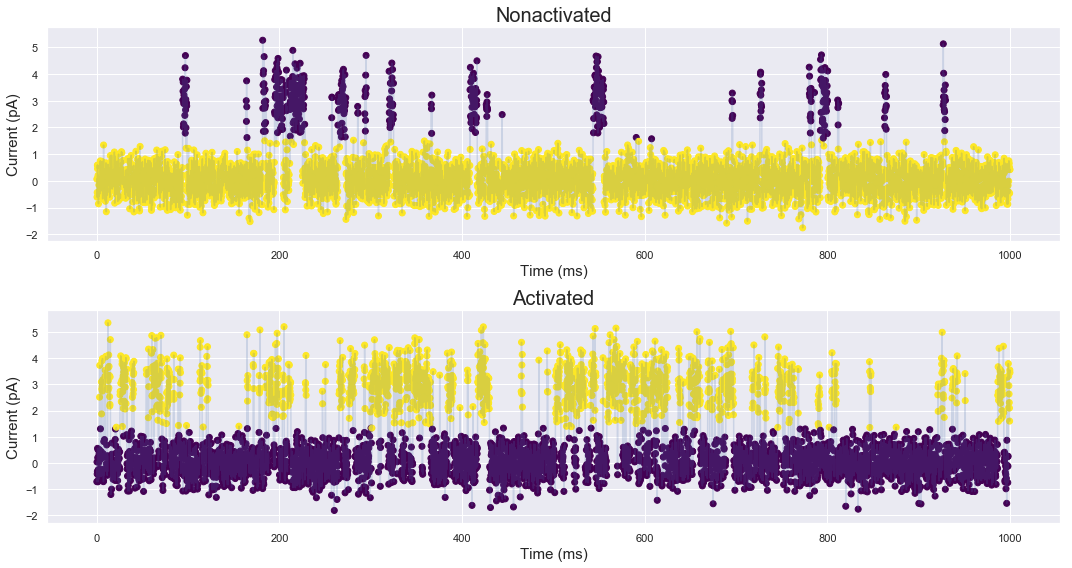

In [5]:
nonactivated_amp_cluster_seq = nonactivated_gmm.predict(nonactivated_current_pA.reshape(-1, 1))
activated_amp_cluster_seq = activated_gmm.predict(activated_current_pA.reshape(-1, 1))

plt.figure(figsize=(15, 8))
n = 5000

plt.subplot(211)
plt.plot(time_ms[:n], nonactivated_current_pA[:n], alpha=0.2)
plt.scatter(time_ms[:n], nonactivated_current_pA[:n], c=nonactivated_amp_cluster_seq[:n], cmap='viridis')
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Current (pA)', fontsize=15)
plt.title('Nonactivated', fontsize=20)

plt.subplot(212)
plt.plot(time_ms[:n], activated_current_pA[:n], alpha=0.2)
plt.scatter(time_ms[:n], activated_current_pA[:n], c=activated_amp_cluster_seq[:n], cmap='viridis')
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Current (pA)', fontsize=15)
plt.title('Activated', fontsize=20)

plt.tight_layout();

---
### 4. (10 pts) From your idealized cluster sequences, generate distributions of closed and open lifetimes. Plot a histogram of these distributions (you do NOT need to use a logscale).

*Hint:* Compute distributions of number of sample points during closures and openings, then convert to times using your sample interval.

*Hint:* Think twice about which cluster corresponds to the closed channel and which to the open channel.

You should end up with four plots, one for both open and closed lifetime distributions for each condition (i.e. nonactivating or activating).

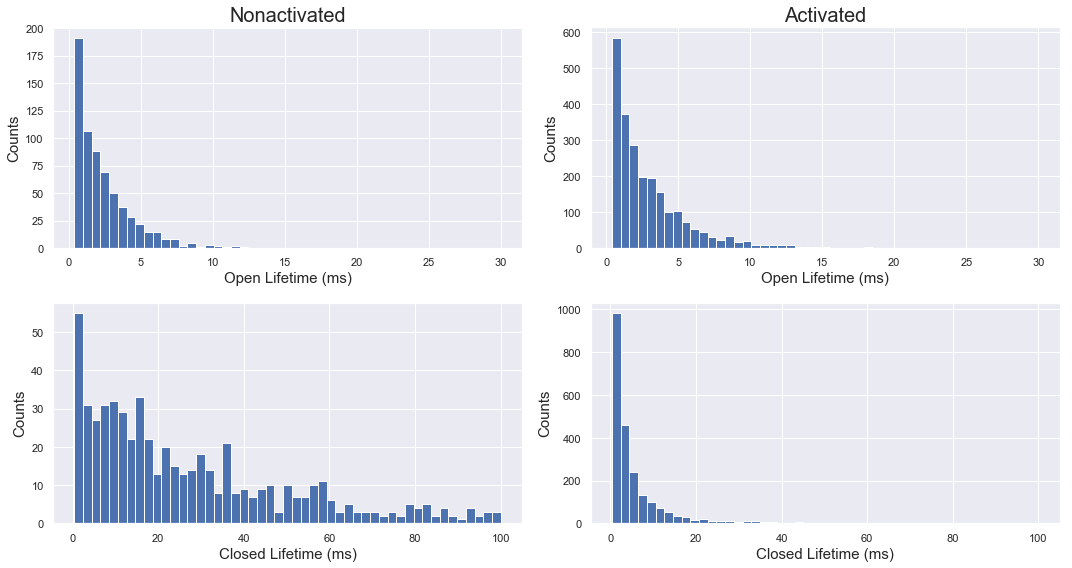

In [6]:
sample_interval_ms = time_ms[1] - time_ms[0]

# for the nonactivated_amp_cluster_seq, 0 = open, 1 = closed
# for the activated_amp_cluster_seq, 0 = closed, 1 = open

co = np.where(np.diff(nonactivated_amp_cluster_seq) == -1)[0]
oc = np.where(np.diff(nonactivated_amp_cluster_seq) == 1)[0]

n = min([len(co), len(oc)])
open_lifetimes_pts = oc[:n] - co[:n]
closed_lifetimes_pts = co[1:n] - oc[:n - 1]

nonactivated_open_lifetimes_ms = open_lifetimes_pts * sample_interval_ms
nonactivated_closed_lifetimes_ms = closed_lifetimes_pts * sample_interval_ms

co = np.where(np.diff(activated_amp_cluster_seq) == 1)[0]
oc = np.where(np.diff(activated_amp_cluster_seq) == -1)[0]

n = min([len(co), len(oc)])
open_lifetimes_pts = oc[:n] - co[:n]
closed_lifetimes_pts = co[1:n] - oc[:n - 1]

activated_open_lifetimes_ms = open_lifetimes_pts * sample_interval_ms
activated_closed_lifetimes_ms = closed_lifetimes_pts * sample_interval_ms

plt.figure(figsize=(15, 8))
open_binedges = np.linspace(2 * sample_interval_ms, 30, 50)
closed_binedges = np.linspace(2 * sample_interval_ms, 100, 50)

plt.subplot(221)
plt.hist(nonactivated_open_lifetimes_ms, open_binedges)
plt.xlabel('Open Lifetime (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Nonactivated', fontsize=20)

plt.subplot(222)
plt.hist(activated_open_lifetimes_ms, open_binedges)
plt.xlabel('Open Lifetime (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Activated', fontsize=20)

plt.subplot(223)
plt.hist(nonactivated_closed_lifetimes_ms, closed_binedges)
plt.xlabel('Closed Lifetime (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15)

plt.subplot(224)
plt.hist(activated_closed_lifetimes_ms, closed_binedges)
plt.xlabel('Closed Lifetime (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15)

plt.tight_layout();

---
### 5. (5 pts) Fit each of the open and closed lifetime distributions with a single exponential probability distribution. Replot the histograms scaled to probability densities overlaid with the exponential fits.

In [7]:
_, nonactivated_open_tau_ms = st.expon.fit(nonactivated_open_lifetimes_ms, floc=0)
_, activated_open_tau_ms = st.expon.fit(activated_open_lifetimes_ms, floc=0)

_, nonactivated_closed_tau_ms = st.expon.fit(nonactivated_closed_lifetimes_ms, floc=0)
_, activated_closed_tau_ms = st.expon.fit(activated_closed_lifetimes_ms, floc=0)

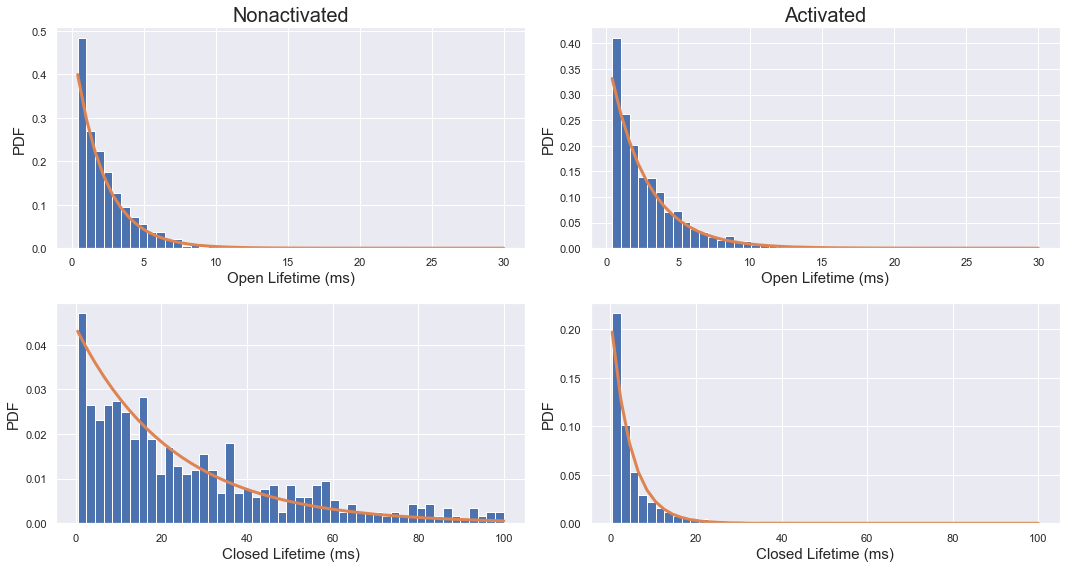

In [8]:
plt.figure(figsize=(15, 8))
open_binedges = np.linspace(2 * sample_interval_ms, 30, 50)
closed_binedges = np.linspace(2 * sample_interval_ms, 100, 50)

plt.subplot(221)
plt.hist(nonactivated_open_lifetimes_ms, open_binedges, density=True)
plt.plot(open_binedges, st.expon.pdf(open_binedges, 0, nonactivated_open_tau_ms), lw=3)
plt.xlabel('Open Lifetime (ms)', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title('Nonactivated', fontsize=20)

plt.subplot(222)
plt.hist(activated_open_lifetimes_ms, open_binedges, density=True)
plt.plot(open_binedges, st.expon.pdf(open_binedges, 0, activated_open_tau_ms), lw=3)
plt.xlabel('Open Lifetime (ms)', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title('Activated', fontsize=20)

plt.subplot(223)
plt.hist(nonactivated_closed_lifetimes_ms, closed_binedges, density=True)
plt.plot(closed_binedges, st.expon.pdf(closed_binedges, 0, nonactivated_closed_tau_ms), lw=3)
plt.xlabel('Closed Lifetime (ms)', fontsize=15)
plt.ylabel('PDF', fontsize=15)

plt.subplot(224)
plt.hist(activated_closed_lifetimes_ms, closed_binedges, density=True)
plt.plot(closed_binedges, st.expon.pdf(closed_binedges, 0, activated_closed_tau_ms), lw=3)
plt.xlabel('Closed Lifetime (ms)', fontsize=15)
plt.ylabel('PDF', fontsize=15)

plt.tight_layout();

---
### 6. (5 pts) What is the major difference between the lifetime distributions in the nonactivated and activated conditions?

Nonactivated channels have longer closed lifetimes, whereas activated channels remain closed for a relatively shorter duration.

---
### 7. (5 pts) Build a Hidden Markov Model with two states (closed and open) and allowed transitions between them. Set the current distributions for each state to a Gaussian with mean and standard deviation close to what you found from your GMM fit to the current amplitude distributions. Start the model off with equal probability to be in either state. Don't worry about the actual transition probabilities at this point, just set the probability of staying in each state after one sample interval to 0.95 and the probability of switching states to 0.05.

In [9]:
hmm = HiddenMarkovModel()

C = State(NormalDistribution(0, 1), name='Closed')
O = State(NormalDistribution(3, 1), name='Open')

hmm.add_states([C, O])

hmm.add_transition(hmm.start, C, 0.5)
hmm.add_transition(hmm.start, O, 0.5)

hmm.add_transition(C, C, 0.95)
hmm.add_transition(C, O, 0.05)
hmm.add_transition(O, O, 0.95)
hmm.add_transition(O, C, 0.05)

hmm.bake()

---
### 8. (5 pts) Optimize the model parameters to best explain the nonactivated current data. Report the transition probability matrix.

In [12]:
hmm.fit([nonactivated_current_pA])

states = [state.name for state in hmm.states[:2]]
nonactivated_transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix()[:2, :2], index=states, columns=states)
nonactivated_transition_probabilities

,Closed,Open
Closed,0.994376,0.005624
Open,0.061253,0.938747


---
### 9. (5 pts) Optimize the model parameters to best explain the activated current data. Report the transition probability matrix.

In [13]:
hmm.fit([activated_current_pA])

states = [state.name for state in hmm.states[:2]]
activated_transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix()[:2, :2], index=states, columns=states)
activated_transition_probabilities

,Closed,Open
Closed,0.966704,0.033296
Open,0.059107,0.940893


---
### 10. (5 pts) What is the major difference between the transition probabilities in the nonactivated and activated conditions? What is pretty much the same between the two conditions?

In comparison to the nonactivated channel, the activated channel is less likely to remain closed (i.e. more likely to open). Once open, the channel remains open for roughly the same amount of time in both nonactivating and activating conditions.